# Environment setup

In [1]:
# Install necessary libraries
!pip install -q openai langchain langchain-openai langchain-community openai-whisper sentence-transformers pdf2image
!apt-get install poppler-utils
!pip install --upgrade Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 20.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import userdata
api_key = userdata.get('OPENAI')

In [4]:
%cd /content/drive/MyDrive/GenAI/RAG/CAPSTONE PROJECT - MultiModal Starbucks Finance

/content/drive/MyDrive/GenAI/RAG/CAPSTONE PROJECT - MultiModal Starbucks Finance


In [5]:
# Import libraries
from langchain_openai import ChatOpenAI
from openai import OpenAI
from IPython.display import display, Markdown
from sentence_transformers import SentenceTransformer
import whisper
import pandas as pd
import base64
from pdf2image import convert_from_path
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import os
import torch

# Audio Transcription

In [6]:
# Check if the GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Checking which models are available
whisper.available_models()

['tiny.en',
 'tiny',
 'base.en',
 'base',
 'small.en',
 'small',
 'medium.en',
 'medium',
 'large-v1',
 'large-v2',
 'large-v3',
 'large',
 'large-v3-turbo',
 'turbo']

In [8]:
# Transcribe the audio using Whisper
model = whisper.load_model(name = 'large-v3-turbo',
                           device = device)
input_file = "starbucks-q3.mp3"
result = model.transcribe(audio = input_file)

100%|█████████████████████████████████████| 1.51G/1.51G [00:55<00:00, 29.1MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [9]:
# Check the transcription output
transcription_text= result['text']
print("Transcription text:")
print(transcription_text)

Transcription text:
 2024. And with that, I'll now tell you the call over to Lakshman. Thank you, Tiffany, and thank you for joining us this afternoon. Let me start by laying out our results for this quarter. Our Q3 total company revenue was $9.1 billion, up 1% year-over-year, and 6% over Q2. Our global comparable store sales declined 3% year-over-year, driven by a negative 2% comp growth in North America and a negative 14% comp growth in China, and partially offset by strong performance in Japan. Our global operating margins contracted by 70 basis points to 16.7%, and overall earnings per share for the quarter was $0.93. Our total company results were in line with guidance, but international performance, particularly in China, was challenged. We are not satisfied with the results, but our actions are making an impact. Leading business and operational indicators are trending in the right direction ahead of our financial results, and our runway for improvement is long. We see green shoo

In [10]:
# Save the transcription to a text file
os.makedirs("transcript", exist_ok = True)
with open("transcript/transcript.txt", "w") as f:
  f.write(transcription_text)

# Embedding the Audio

In [11]:
# Loading the transcription text into chunks of 100 characters
with open("transcript/transcript.txt", 'r') as f:
  text = f.read()

chunk_size = 250
audio_chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Summary of the chunks
print(f"Number of chunks: {len(audio_chunks)}")
print(f"First chunk: {audio_chunks[0]}")

Number of chunks: 58
First chunk:  2024. And with that, I'll now tell you the call over to Lakshman. Thank you, Tiffany, and thank you for joining us this afternoon. Let me start by laying out our results for this quarter. Our Q3 total company revenue was $9.1 billion, up 1% year-ove


In [12]:
# Load the Clip model and embed the chunks
clip_model = SentenceTransformer("clip-ViT-B-32", device = device)
audio_embeddings = clip_model.encode(audio_chunks)

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel%2Ftokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel%2Fconfig.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel%2Fvocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel%2Fspecial_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel%2Fpreprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

In [13]:
# Check the shape of the embeddings
print(f"shape of embeddings: {audio_embeddings.shape}")

shape of embeddings: (58, 512)


# PDF to image transformation

In [14]:
# Defining the paths for the PDF and the images
pdf_path = '3Q24-Earnings-Release.pdf'
output_folder = 'images'
os.makedirs(output_folder, exist_ok = True)

In [15]:
# Convert each page of PDF to images
images = convert_from_path(pdf_path)
image_paths = []

for i, image in enumerate(images):
  image_path = os.path.join(output_folder, f"page_{i+1}.jpg")
  image.save(image_path, "JPEG")
  image_paths.append(image_path)

print(f"Number of images/pages is {len(image_paths)}")
print(f"Examples of 3 image paths {image_paths[:3]}")

Number of images/pages is 17
Examples of 3 image paths ['images/page_1.jpg', 'images/page_2.jpg', 'images/page_3.jpg']


# Embedding the images


In [16]:
# Using the clip model to embed images
image_embeddings = []

for filename in os.listdir(output_folder):
  if filename.endswith("jpg"):
    image_path = os.path.join(output_folder, filename)
    image = Image.open(image_path)
    embedding = clip_model.encode(image)
    image_embeddings.append(embedding)

In [17]:
# Check the imag embeddings
print(f"Shape of image embeddings: {len(image_embeddings)}")
print(f"The shape of embeddings is: {image_embeddings[0].shape}")

Shape of image embeddings: 17
The shape of embeddings is: (512,)


# Retrieval System

In [18]:
# Defining a query
query = "What are the short term risks for the company"
query_embeddings = clip_model.encode(query)

In [19]:
# Compute the similarity with the transcription embeddings
audio_similarities = cosine_similarity([query_embeddings], audio_embeddings)[0]

In [20]:
# Order the top K (20) most similar audios
k = 20
top_k_audio_similarities = audio_similarities.argsort()[-k:][::-1]

In [21]:
# Show the most similar audios and their similarities
print(f"The top 5 most similar chunks are {top_k_audio_similarities[:5]}")
print(f"The corresponding similarities are {audio_similarities[top_k_audio_similarities[:20]]}")

The top 5 most similar chunks are [33 49 50 46 48]
The corresponding similarities are [0.8553849  0.84822136 0.84667623 0.8423403  0.8272289  0.81898
 0.8168866  0.8146637  0.81367695 0.8062173  0.8024574  0.7962681
 0.794362   0.7819918  0.77714515 0.77608323 0.7759909  0.77526295
 0.7752605  0.7745338 ]


In [22]:
# Compute the cosine similarity with the image embeddings
image_similarities = cosine_similarity([query_embeddings], image_embeddings)[0]

In [23]:
# Print the top k images in terms of similarities
k = 5
top_k_image_similarities = image_similarities.argsort()[-k:][::1]

In [24]:
# Display the top 5 images
print(f"The top 5 most similar images are {top_k_image_similarities[:5]}")
print(f"The corresponding similarities are {image_similarities[top_k_image_similarities[:20]]}")

The top 5 most similar images are [ 7 12  3 15 14]
The corresponding similarities are [0.25334686 0.2551114  0.25643957 0.2597667  0.2644042 ]


# Prepare the context

In [25]:
# Combine the top k transcriptions
k = 5
text_context = ' '.join([audio_chunks[idx] for idx in top_k_audio_similarities[:k]])

In [27]:
# Retrieve the top k images and transform into base65
base64frame = []
for idx in top_k_image_similarities[:k]:
  image_path = image_paths[idx]
  with open(image_path, 'rb') as image_file:
    base64frame.append(base64.b64encode(image_file.read()).decode('utf-8'))


# Generative System

In [28]:
# Connecting to the OpenAI API
client = OpenAI(api_key = api_key)

In [42]:
# Define the system prompt
system_prompt = f"""
### Persona
You are a financial expert Consult in publicly traded companies.
---
### Task
Based on {query} provided,
you explain in clear terms with the data available ONlY
---
You always think step-by-step
"""

[{'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}},
 {'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}},
 {'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}},
 {'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}},
 {'type': 'image_url',
  'image_url': {'url': '',
   'detail': 'high'}}]
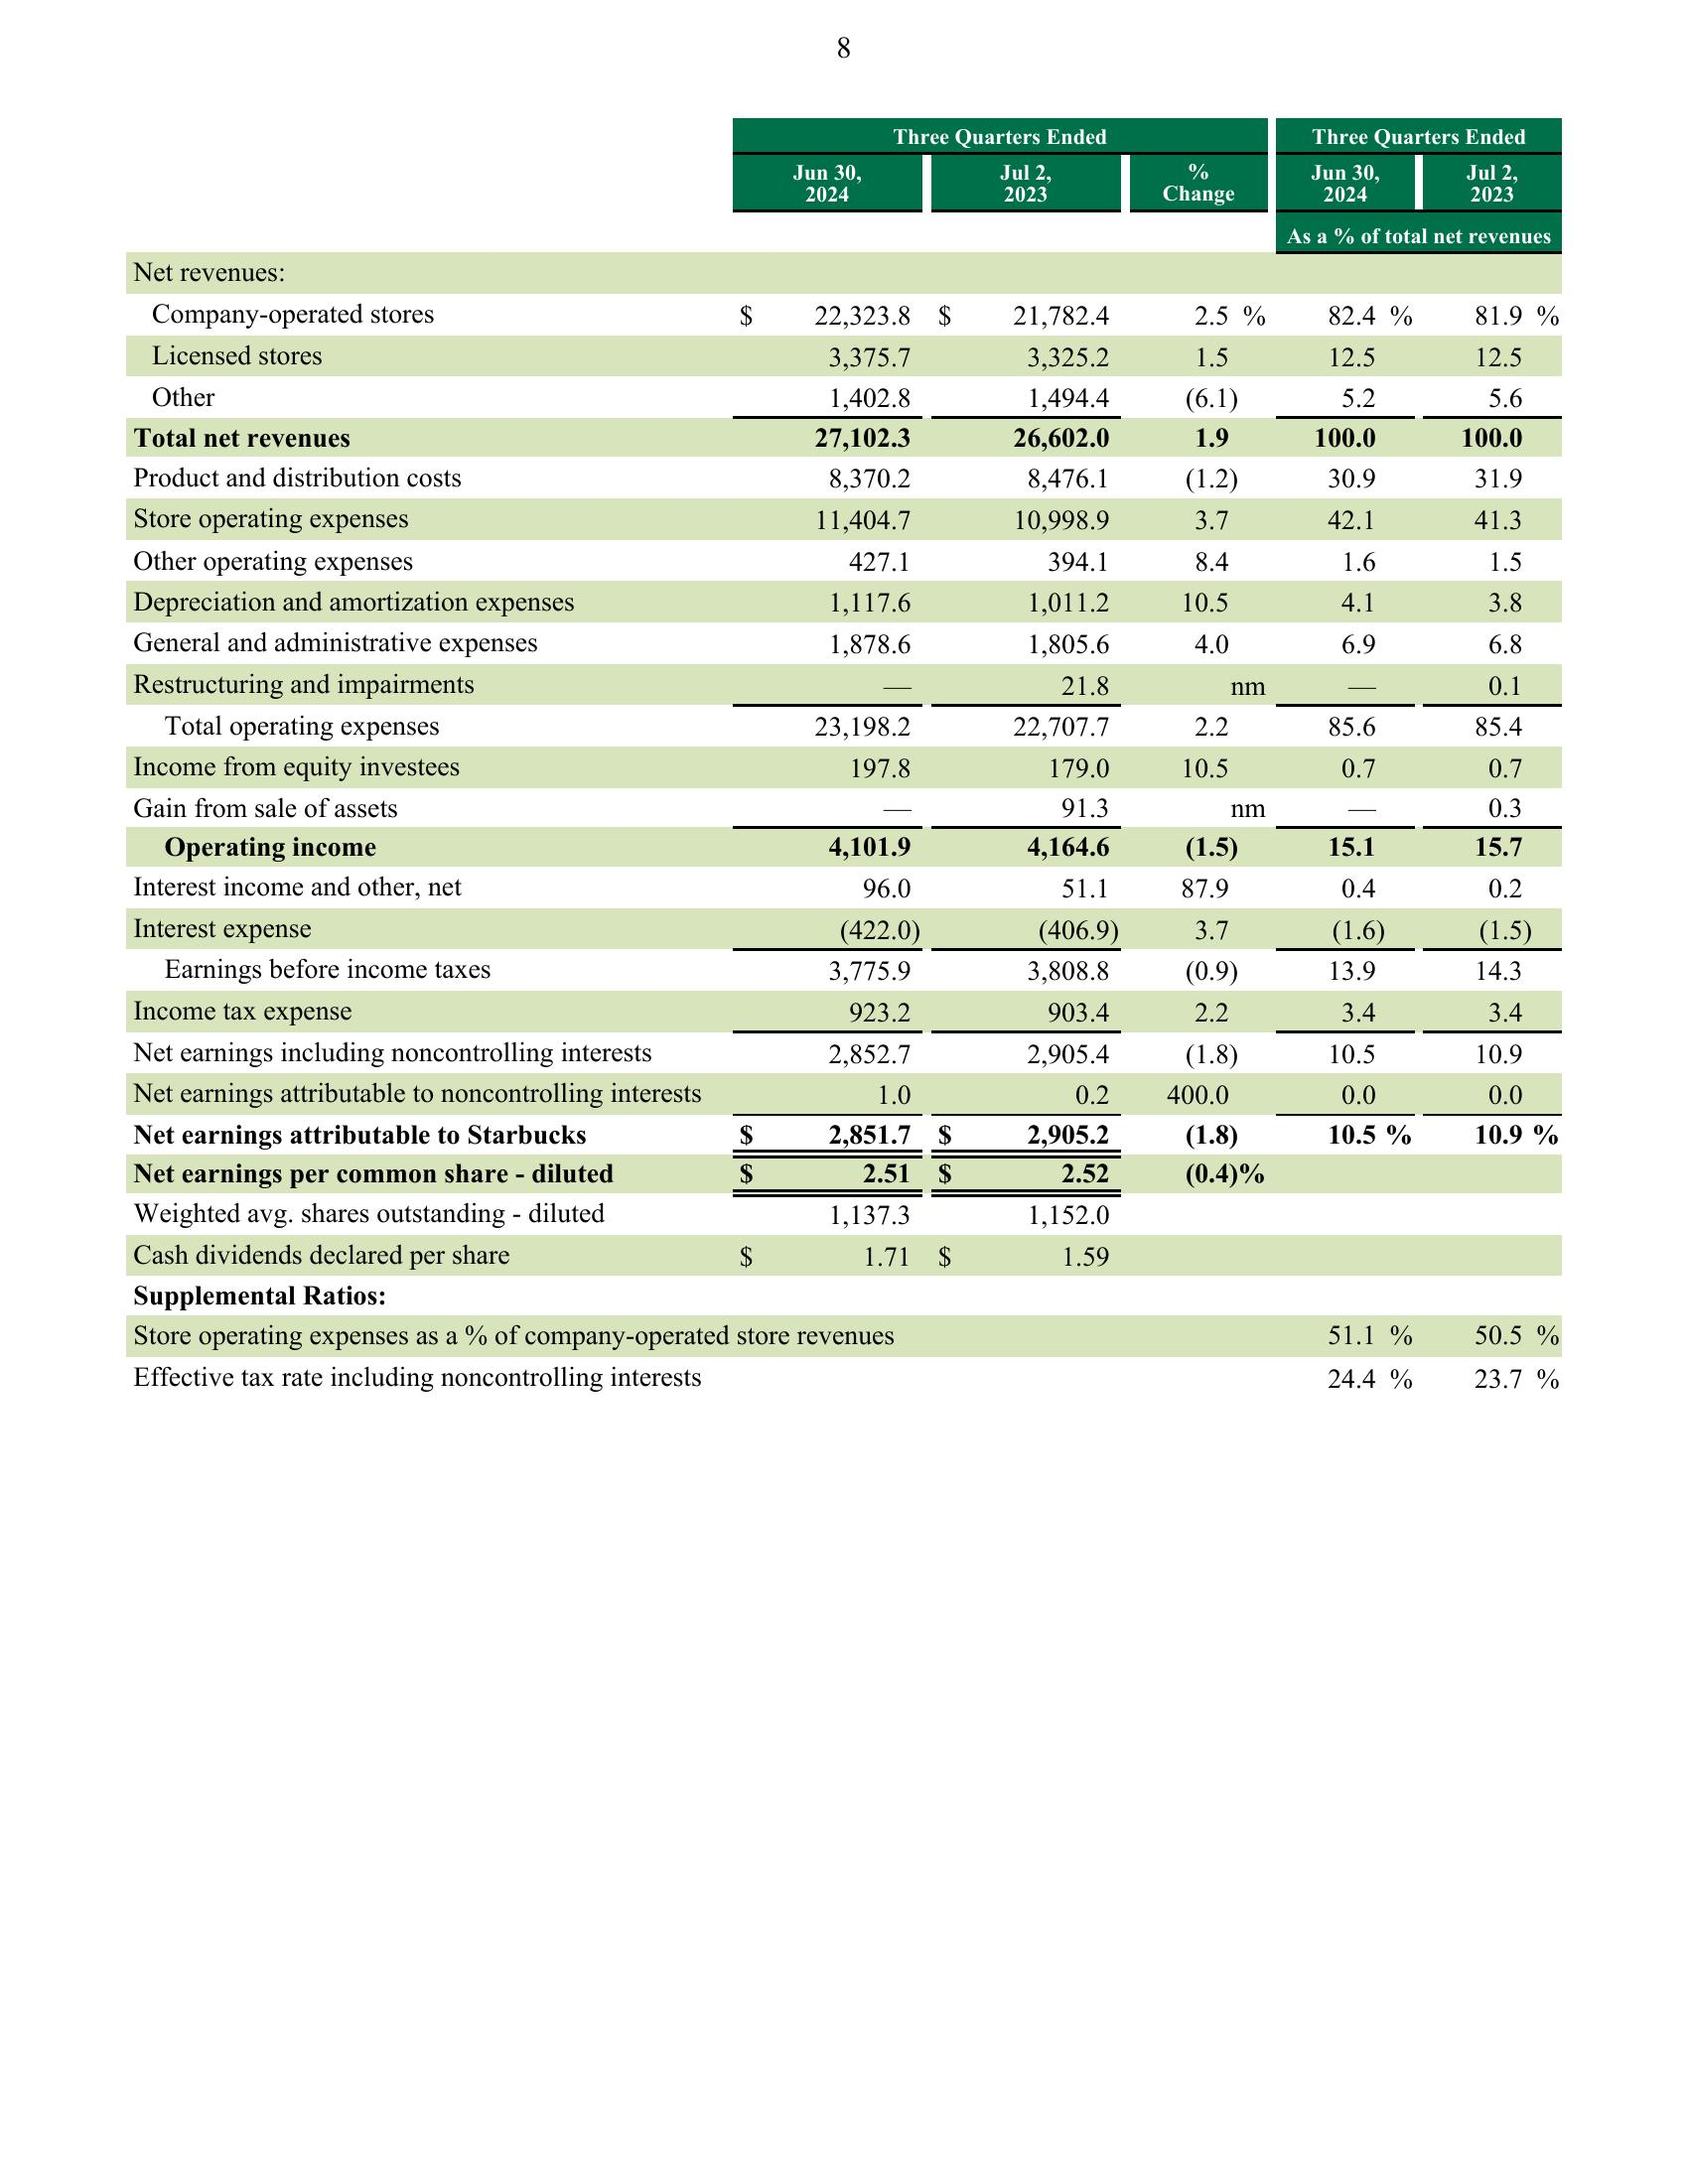
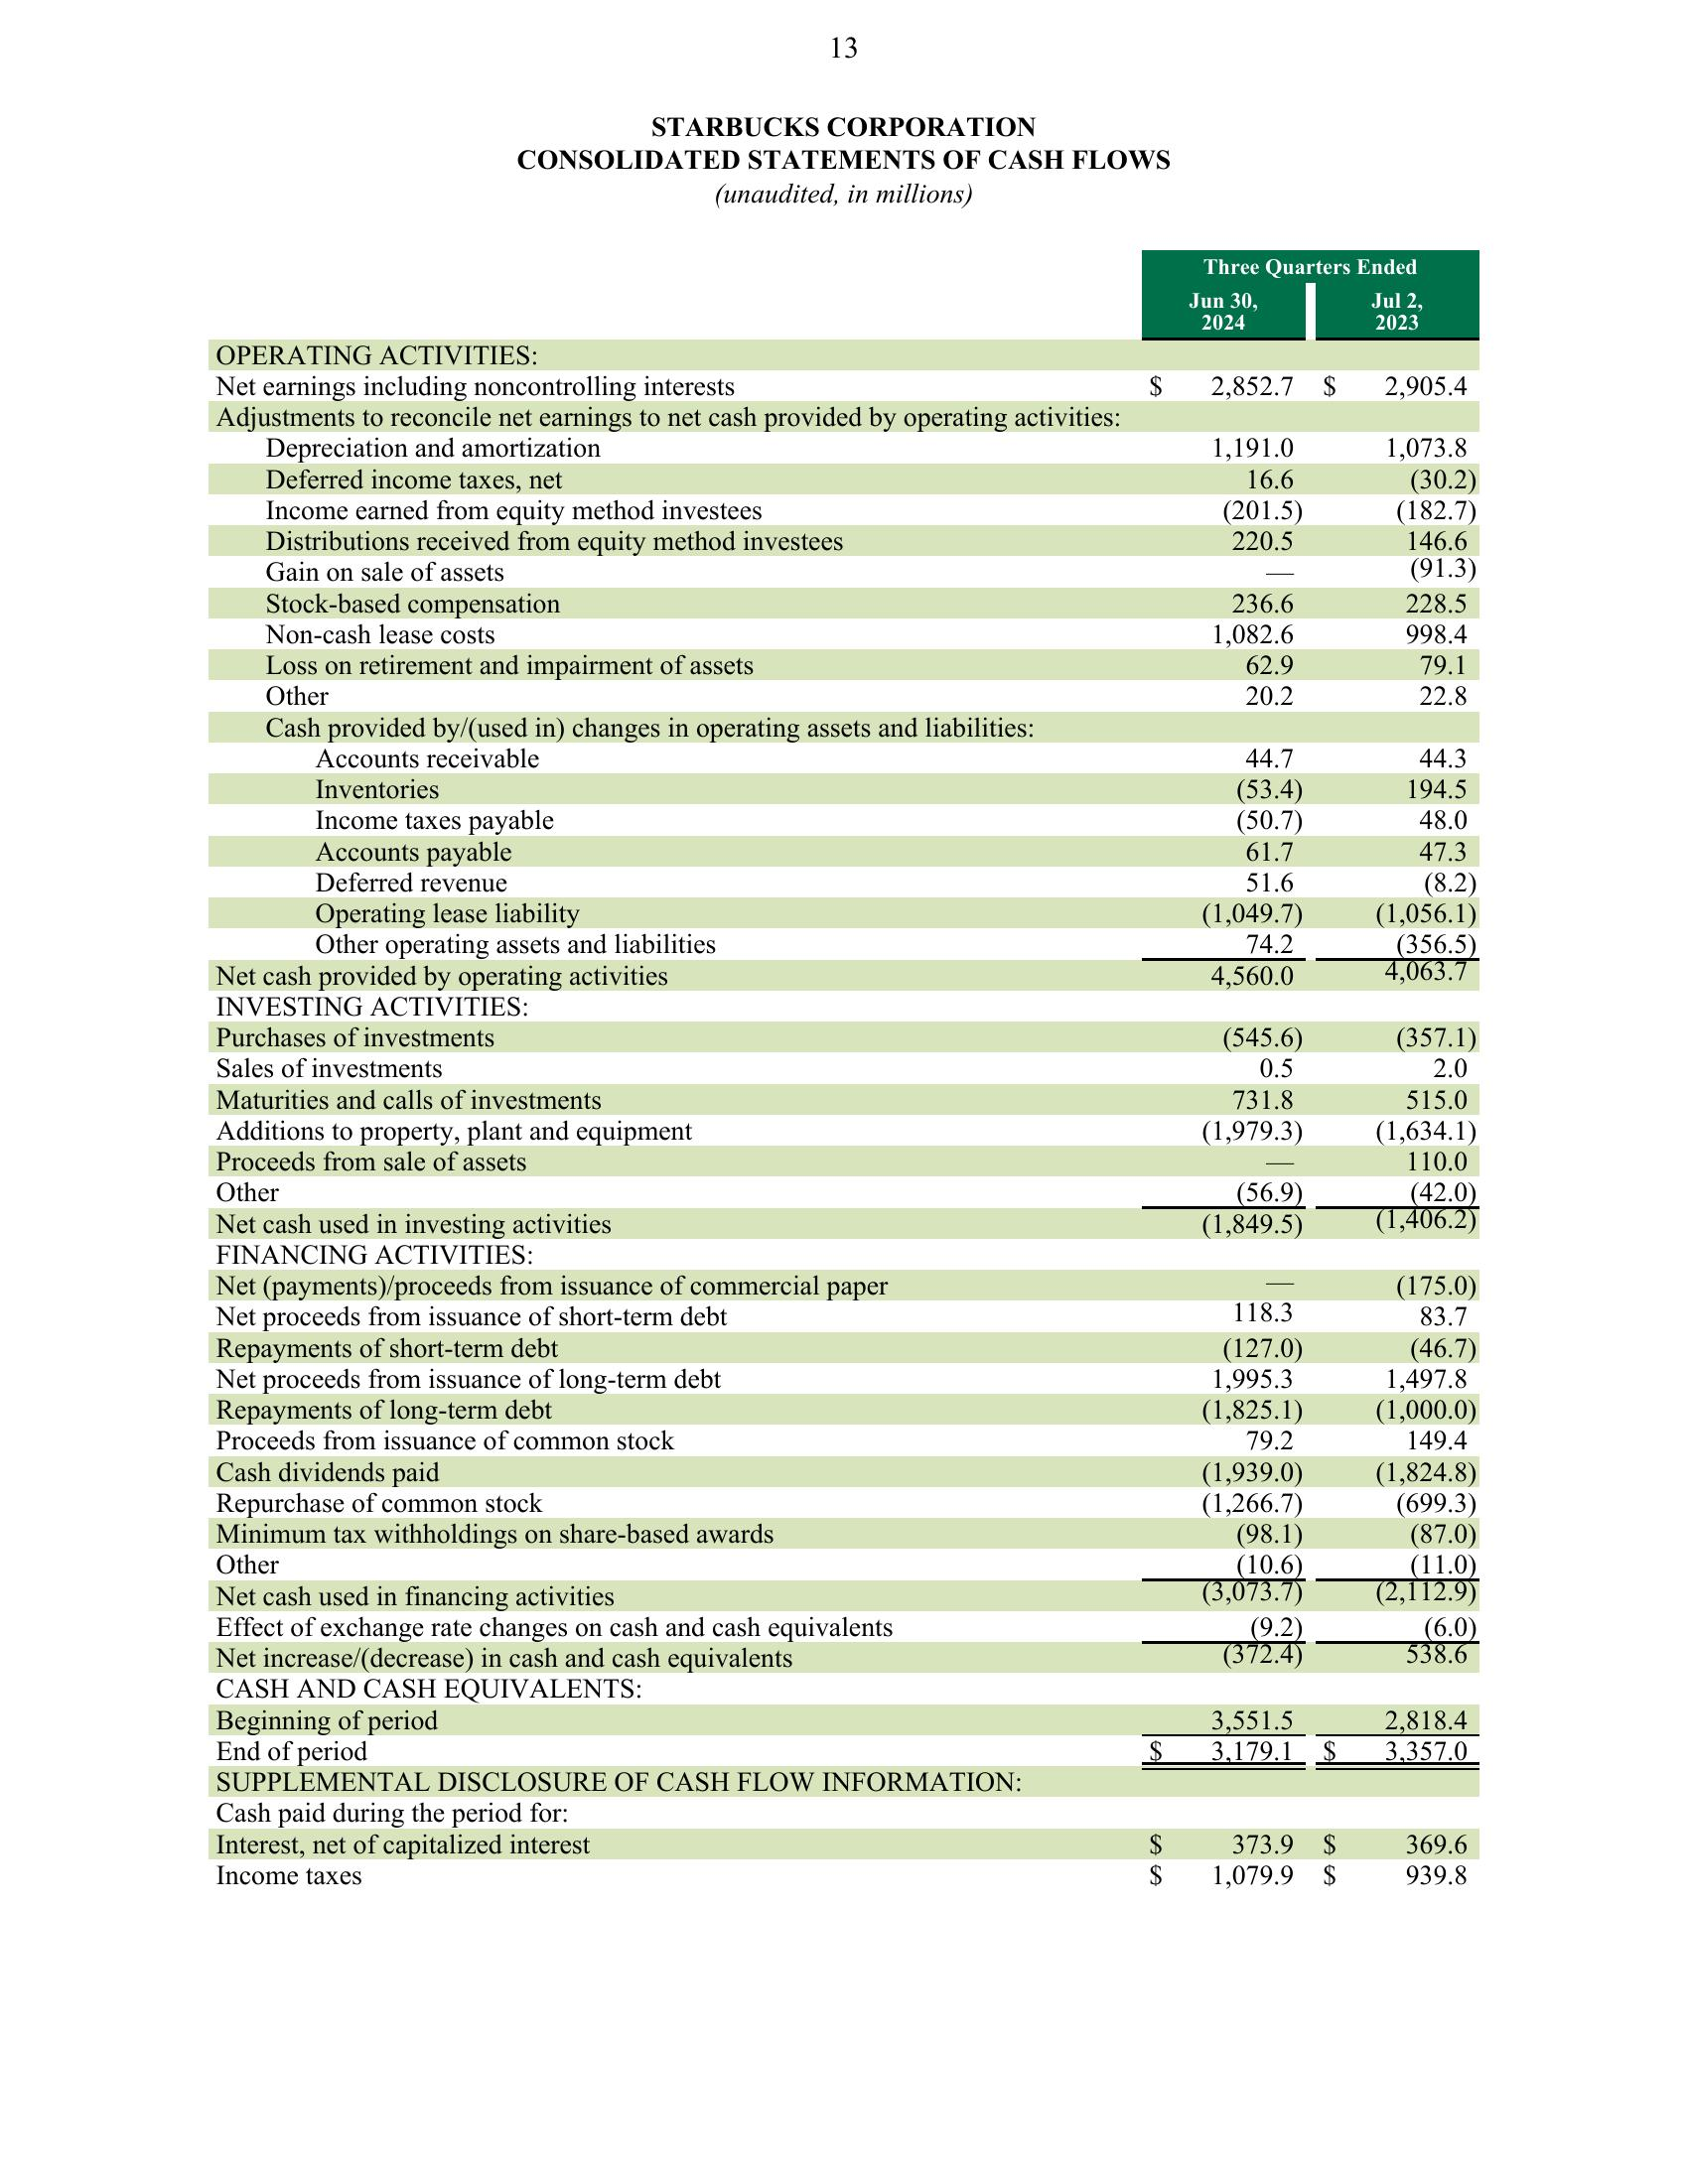
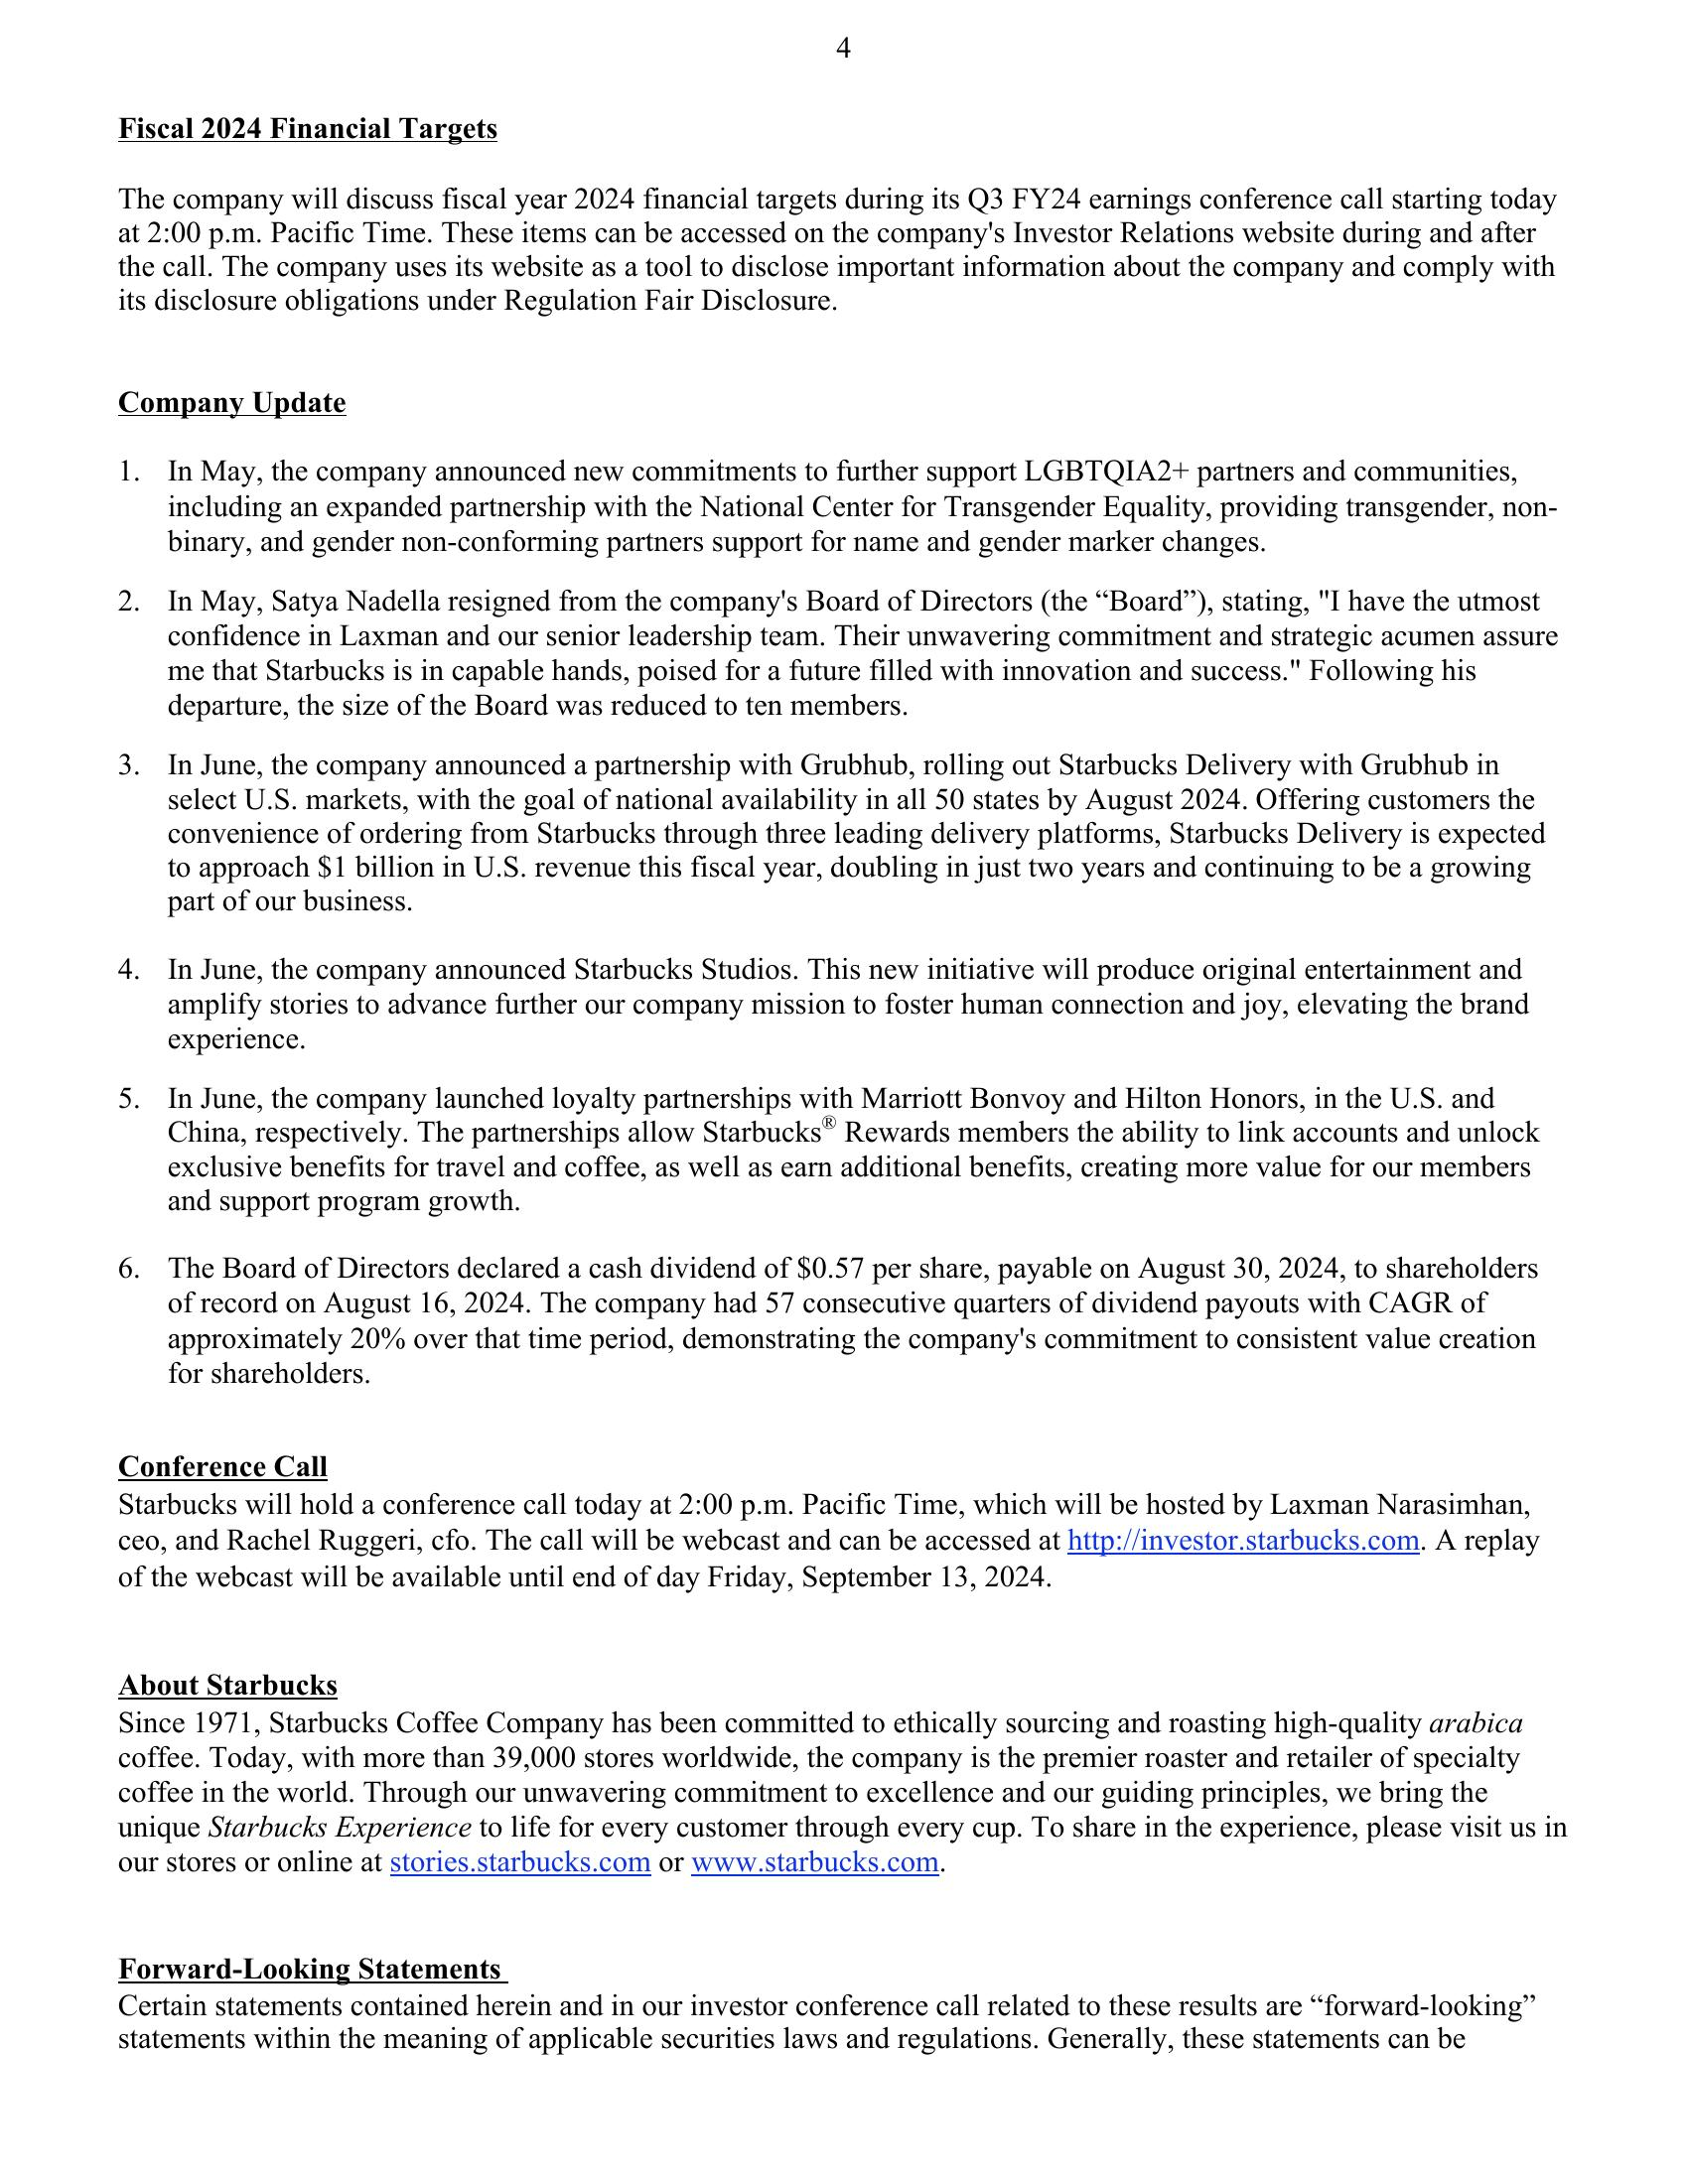
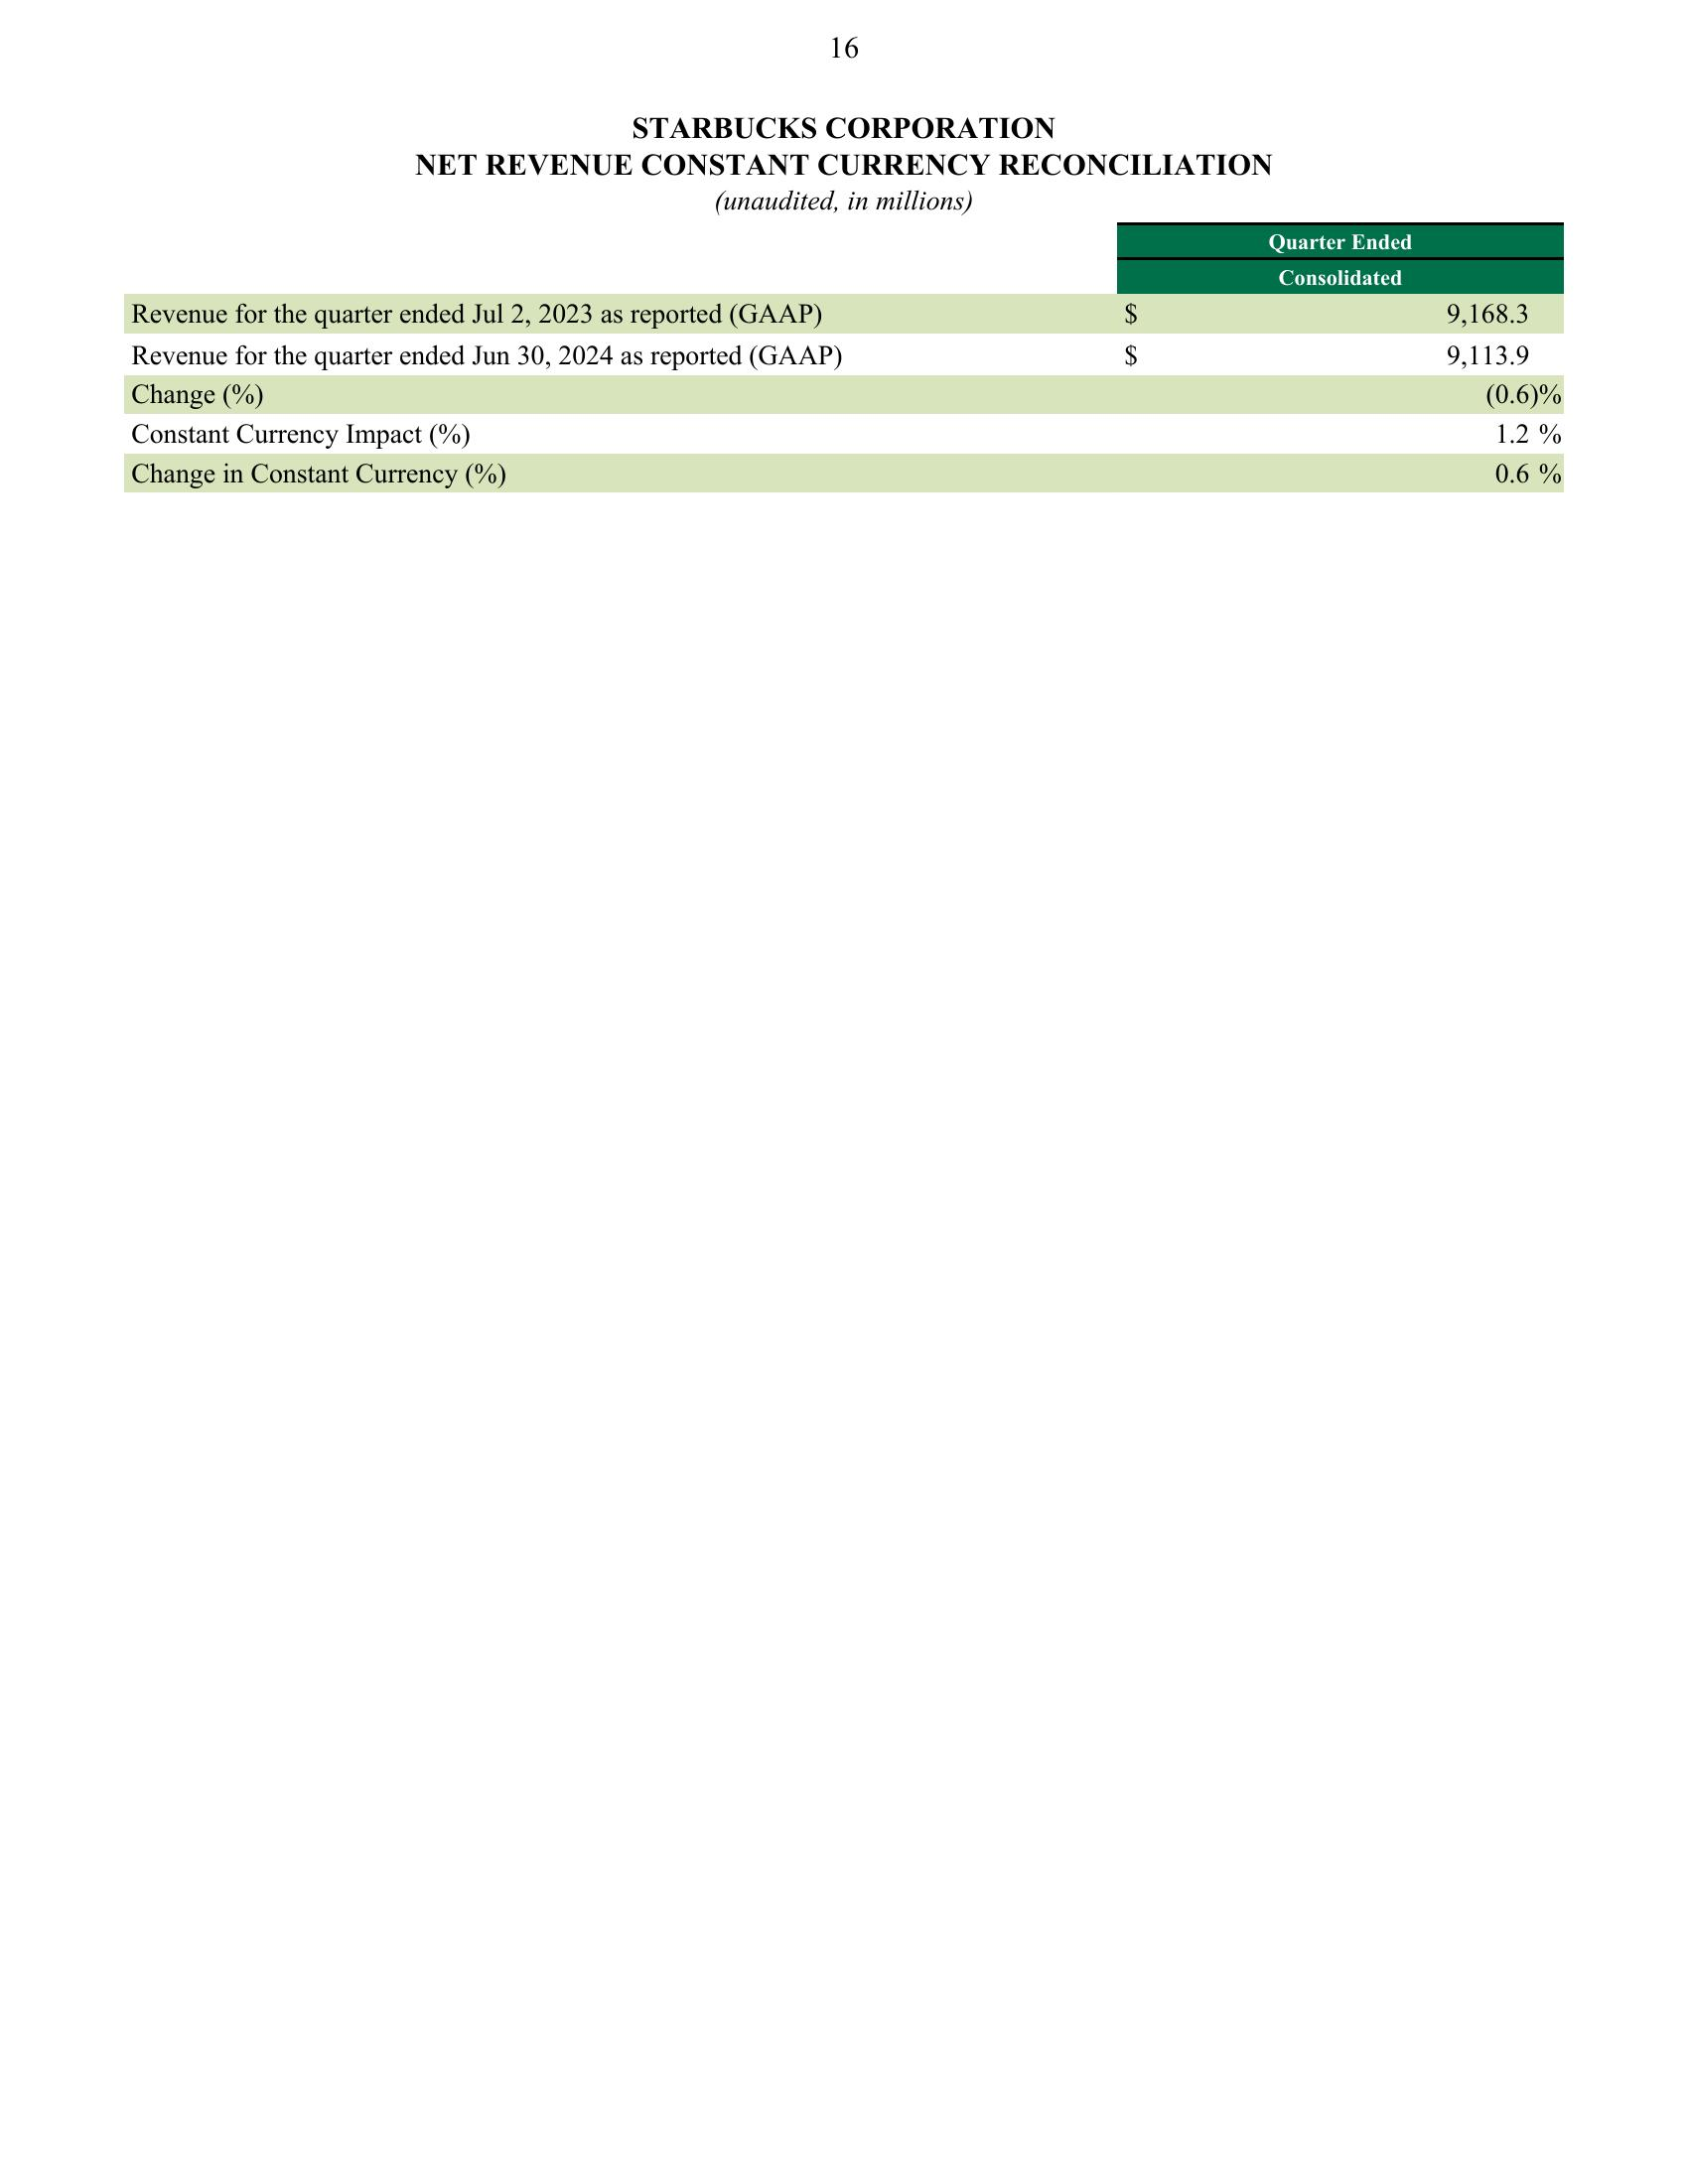
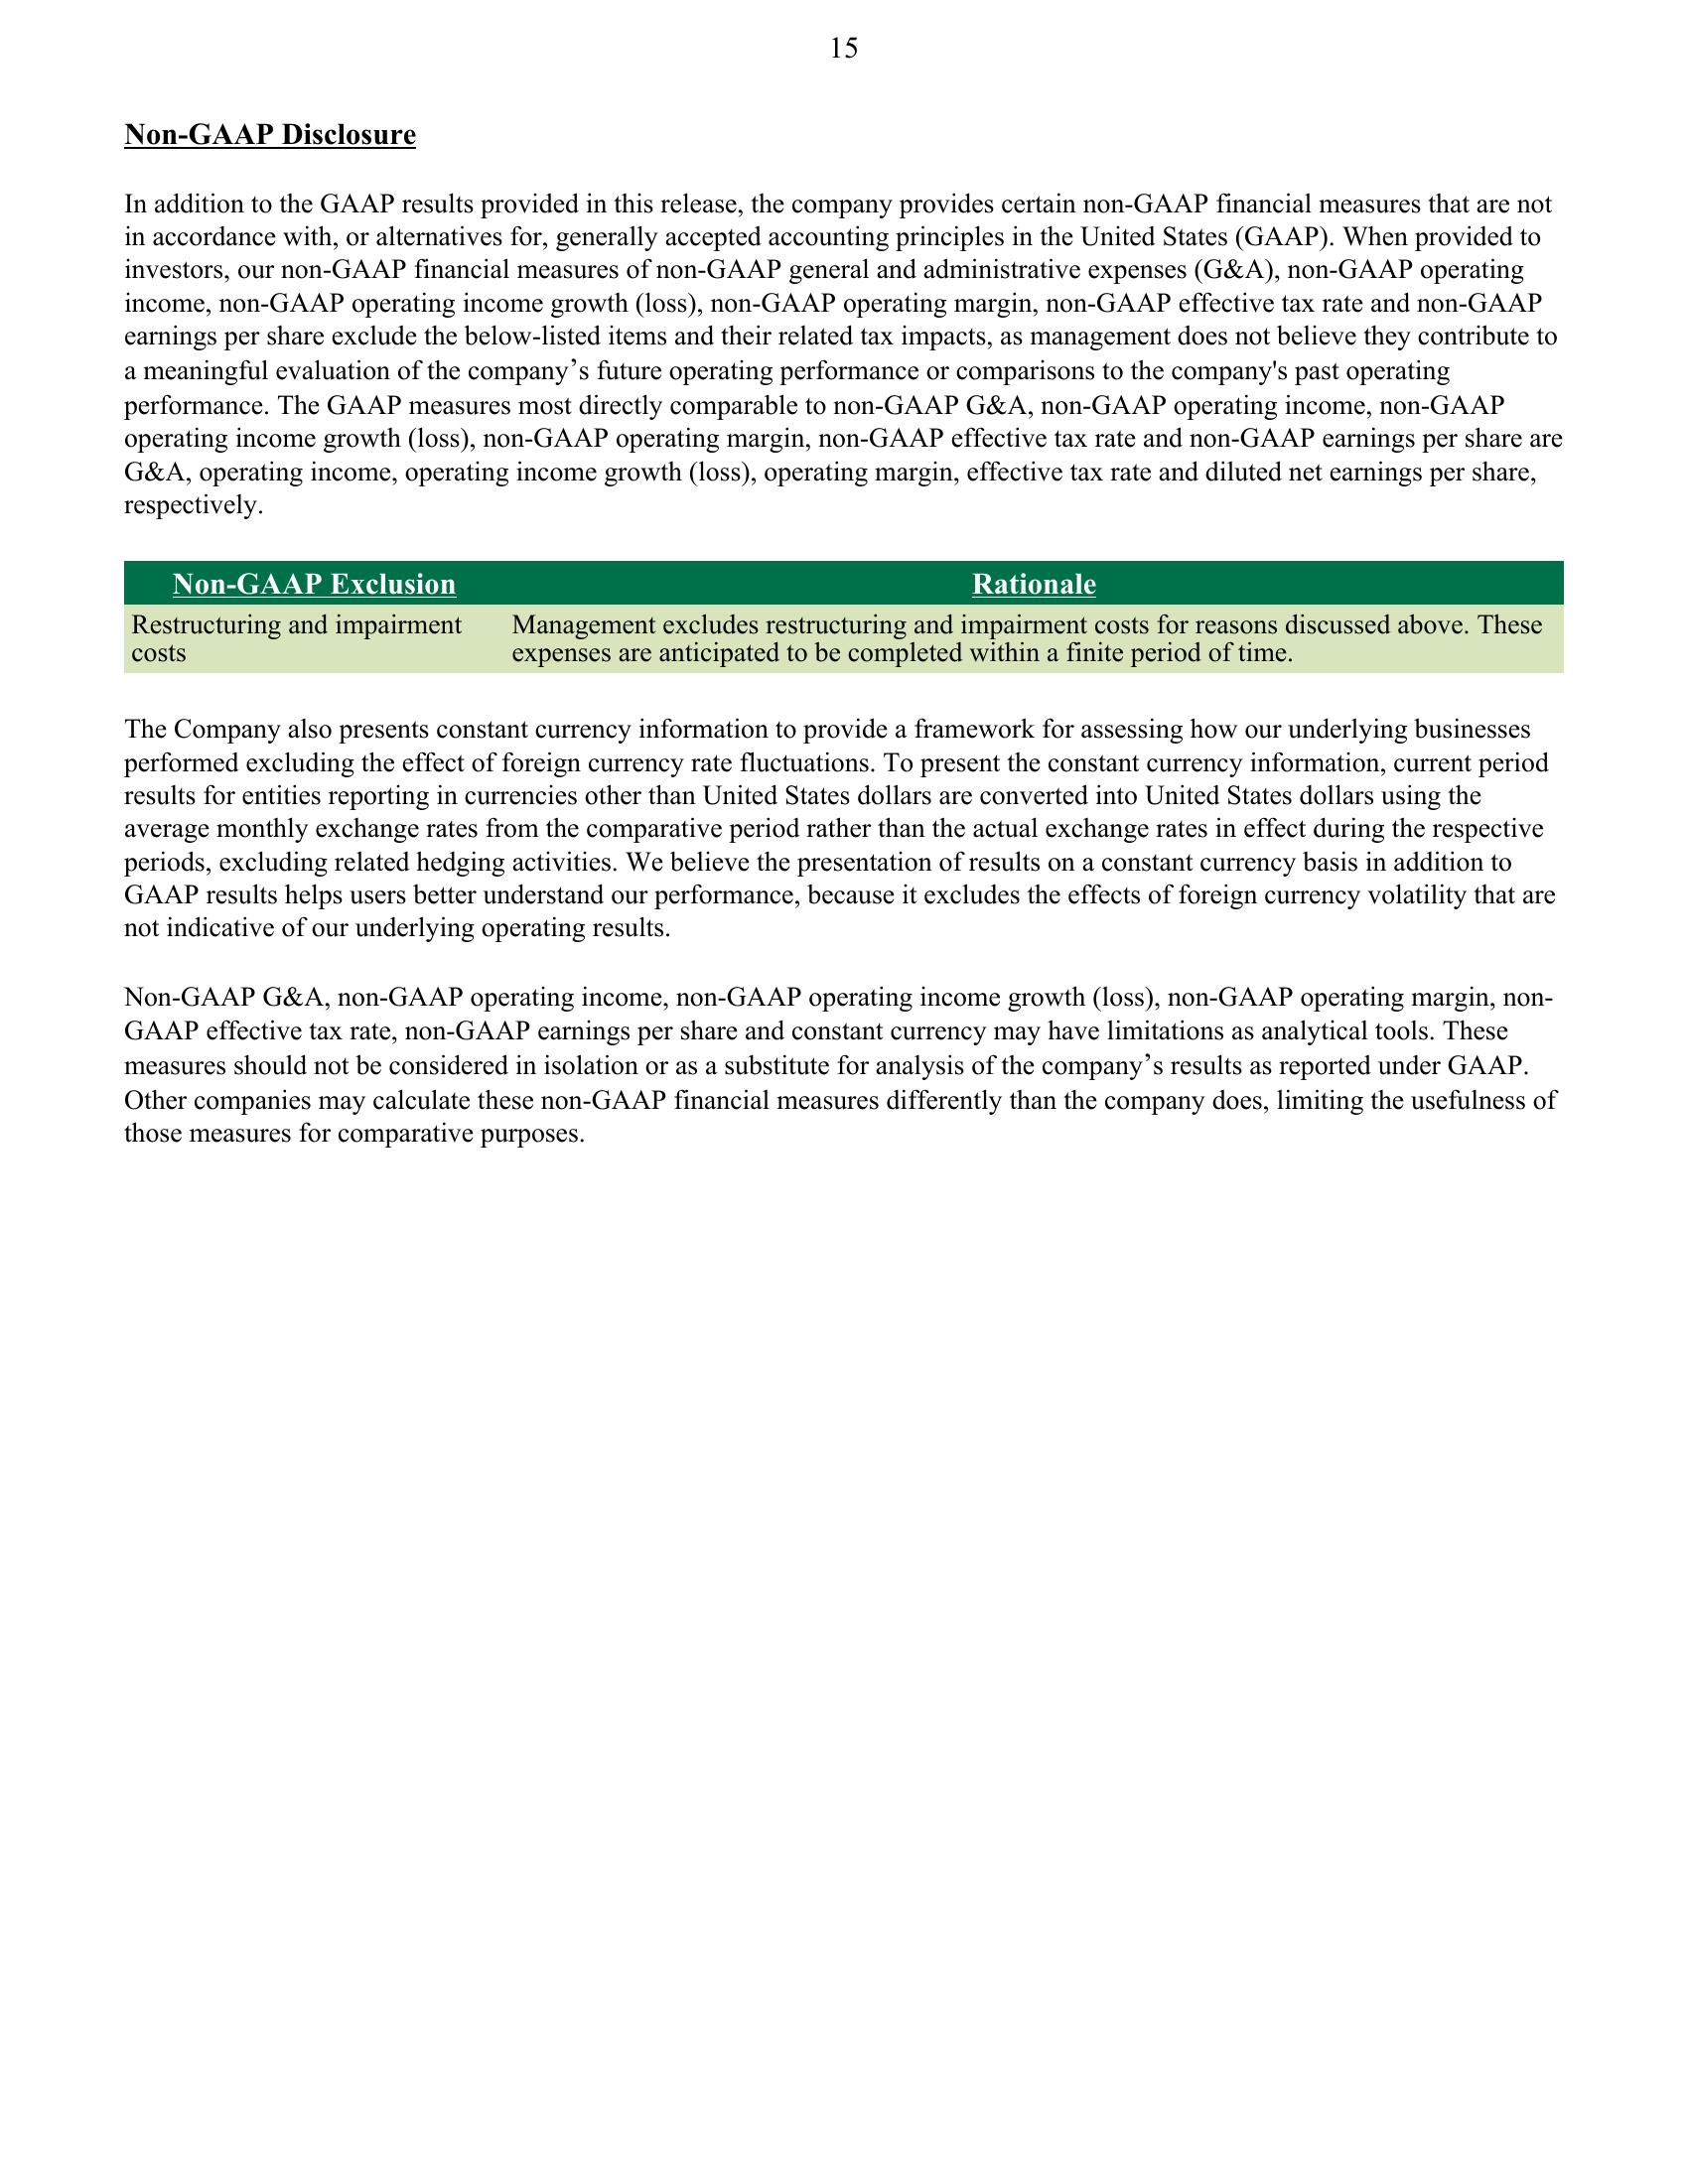

In [43]:
# Prepare the list of images
image_data_list = [{"type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{img}",
                                  "detail": "high"}} for img in base64frame]
image_data_list

In [44]:
# Prepare the message content
user_message_content = [
    {"type": "text", "text": text_context},
    *image_data_list
]

# Or add each image to the user message content indivudually
# user_message_content.extend(image_data_list)

In [45]:
# Generate the naswer
response = client.chat.completions.create(
    model = 'gpt-4o-mini',
    messages = [
        {'role': "system", "content": system_prompt},
        {"role": "user", "content": user_message_content}
    ],
    temperature = 0.2
)

# Display the generated answer
display(Markdown(response.choices[0].message.content))

Based on the provided information, here are the short-term risks for Starbucks:

### 1. **International Market Weakness**
   - **Regions Affected**: There are noted weaknesses in the Middle East, Southeast Asia, and parts of Europe. Misperceptions about the brand are contributing to these challenges.
   - **Consumer Behavior**: In some European markets, consumers are financially stretched, which could lead to reduced spending on premium products like Starbucks.

### 2. **China Market Challenges**
   - **Competitive Landscape**: China is highlighted as a significant challenge, indicating increased competition and possibly changing consumer preferences that could impact sales.
   - **Market Penetration**: The ability to effectively penetrate and grow in this market is crucial, and any setbacks could have a substantial impact on overall revenue.

### 3. **Operational Costs**
   - **Rising Expenses**: Store operating expenses increased by 3.7%, which could pressure margins if revenue growth does not keep pace.
   - **General and Administrative Expenses**: These expenses also rose by 4.0%, indicating potential inefficiencies or increased costs that could affect profitability.

### 4. **Currency Fluctuations**
   - **Impact on Revenue**: The constant currency impact shows a slight increase, but fluctuations can still affect international revenue streams, particularly in volatile markets.

### 5. **Dependence on U.S. Market**
   - **U.S. Performance**: While there is confidence in the U.S. business trajectory, over-reliance on this market could be risky if economic conditions change or if competition intensifies.

### 6. **Dividend Payments**
   - **Cash Flow Management**: The company declared a cash dividend of $0.57 per share, which reflects a commitment to returning value to shareholders. However, maintaining this while managing operational challenges could strain cash flow.

### Conclusion
Starbucks faces several short-term risks primarily related to international market performance, rising operational costs, and dependence on the U.S. market. Addressing these challenges effectively will be crucial for maintaining growth and profitability in the near term.